## Motivating Graphs 

In [80]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn import (
    linear_model, metrics, neural_network, pipeline, preprocessing, model_selection
)

In [53]:
#this file contains judges attributes and their ideology
#negative ideology score = liberal, positive ideology score = conservative
#zero is the approximately the median/centrist score
judges = pd.read_csv("Judge Attribute and Ideology.csv")

#ideology data are not consistent before 1956
judges = judges[judges["Year of Appointment"] > 1956]


#rescaling the ideology variable for presentation
judges["Ideology Score"] = 100*judges["Ideology Score"]

#the absolute value of the ideology score measures a judge's distance from the ideological centre
judges["Absolute Ideology"] = abs(judges["Ideology Score"])

#the dataset includes attributes of judges including:
#gender, race, age, politican party, past experience (including in politics)
judges.head()

,Name,Circuit,ID,Appointing President,Appointing President Party,Year of Departure,Year of Birth,Year of Death,President when Departed,Reason for Departing,...,Previous Position - ada,Previous Position - da,Previous Position - lother,Previous Position - lotherl,Previous Position - lawprof,Previous Position - private,Politician,Age When Appointed,Ideology Score,Absolute Ideology
2,"Acker, William Marsh, Jr.",11,10,Reagan,Republican,1996,1927.0,9999.0,Clinton,Retired,...,0,0,0,0,0,1,0,55.0,40.700001,40.700001
3,"Ackerman, Harold Arnold",3,15,Carter,Democrat,1994,1928.0,9999.0,Clinton,Retired,...,0,0,0,0,0,1,1,51.0,-30.599999,30.599999
4,"Ackerman, James Waldo",7,20,Ford,Republican,1984,1926.0,1984.0,Reagan,Died,...,0,0,1,1,0,1,0,50.0,6.100000,6.100000
5,"Acosta, Raymond L.",1,25,Reagan,Republican,1994,1925.0,9999.0,Clinton,Retired,...,0,0,0,0,0,1,0,57.0,53.799999,53.799999
8,"Adams, John R.",6,30323,"Bush, 43",Republican,9999,1955.0,9999.0,Active Ser.,Active Service,...,0,0,0,0,0,0,0,48.0,16.850001,16.850001


In [54]:
#to provide motivation for our analysis, we will create a graph
#showing how the average ideology of judges shifts over time 

#Dataframe with mean ideology and absolute ideology by year
year_ideology = judges.groupby("Year of Appointment")[["Absolute Ideology","Ideology Score"]].mean()
year_ideology.reset_index(inplace = True)


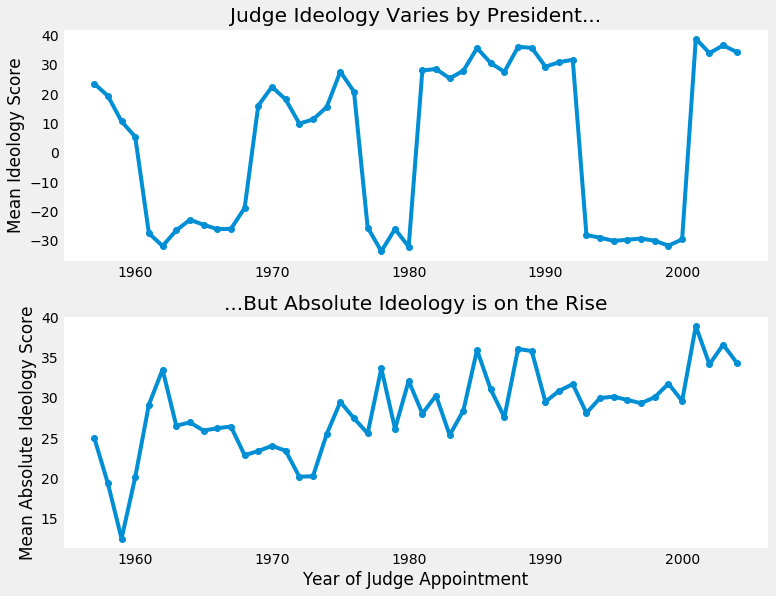

In [81]:
plt.style.use("fivethirtyeight")

fig, ax = plt.subplots(2,1,figsize=(11,8.5))

# Hide grid lines, set a white face color, and set yaxis label
for counter, value in enumerate(["Mean Ideology Score","Mean Absolute Ideology Score"]):
    ax[counter].set_facecolor('white')
    ax[counter].grid(False)
    ax[counter].set_ylabel(value)

#Plot mean ideology, absolute ideology over time 
for counter, value in enumerate(["Ideology Score","Absolute Ideology"]):
    ax[counter].plot(year_ideology["Year of Appointment"],
                    year_ideology[value],"-o")
      
ax[0].set_title("Judge Ideology Varies by President...")   
ax[1].set_title("...But Absolute Ideology is on the Rise")

ax[1].set_xlabel("Year of Judge Appointment")


fig.tight_layout()


In [56]:
#the graph above showed judges have become more ideological.
#our next question is whether this trend occurred in Democratic judges,  Republican judges, or both?

#since ideology varies so much based on the president in power, we'll look at the judge's year of birth,
#rather than year of appointment to see whether newer judges are more ideoligical than older ones

age_ideology = judges.groupby(["Year of Birth","Judge Party"])[["Ideology Score","Absolute Ideology"]].mean()
age_ideology.reset_index(inplace = True)


Text(0, 0.5, 'Mean Ideology Score')

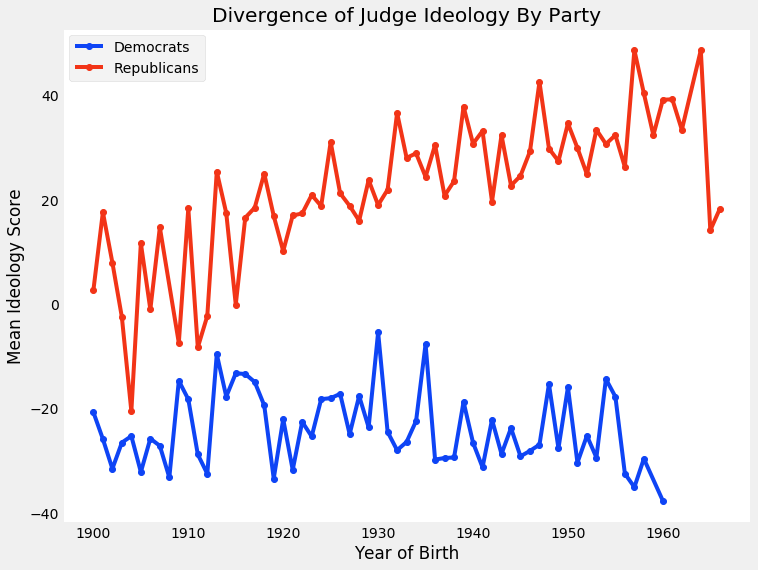

In [57]:
fig, ax = plt.subplots(figsize=(11,8.5))

ax.set_facecolor('white')
ax.grid(False)

#data is sparse before 1900 
initial_age = 1900

recent = age_ideology["Year of Birth"] >= initial_age

democrats = age_ideology["Judge Party"] == "Democrat"
republicans = age_ideology["Judge Party"] == "Republican"

ax.plot(age_ideology[democrats & recent]["Year of Birth"],
        age_ideology[democrats & recent]["Ideology Score"],"-o",label="Democrats",color="#0e44f5")

ax.plot(age_ideology[republicans & recent]["Year of Birth"],
        age_ideology[republicans & recent]["Ideology Score"],"-o",label="Republicans",color="#f23417")


ax.legend()
ax.set_title("Divergence of Judge Ideology By Party")

ax.set_xlabel("Year of Birth")
ax.set_ylabel("Mean Ideology Score")
#fig.tight_layout()

## Predicting Judge Ideology using Attributes

In [58]:
#now we turn to whether attributes of a judge can explain their ideology
import sklearn

from sklearn import (
    linear_model, metrics, neural_network, pipeline,
    model_selection, tree
)

from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import cross_val_score

In [59]:
#We will prepare the data for prediction 

def prep_data(df, continuous_variables, categories, y_var, test_size=0.15):

    ohe = preprocessing.OneHotEncoder(sparse=False)

    y = df[y_var].values
    X = np.zeros((y.size, 0))

    # Add continuous variables if exist
    if len(continuous_variables) > 0:
        X = np.hstack([X, df[continuous_variables].values])

    if len(categories) > 0:
        X = np.hstack([X, ohe.fit_transform(df[categories])])

    X_train, X_test, y_train, y_test = model_selection.train_test_split(
        X, y, test_size=test_size, random_state=42
    )

    return X_train, X_test, y_train, y_test

In [60]:
#This function will allow us to compare the MSE's of each model
def fit_and_report_mses(mod, X_train, X_test, y_train, y_test):
    mod.fit(X_train, y_train)
    return dict(
        mse_train=metrics.mean_squared_error(y_train, mod.predict(X_train)),
        mse_test=metrics.mean_squared_error(y_test, mod.predict(X_test))
    )

In [61]:
#Dropping everything but the regressors and the outcome variable
#Net Worth and Assets have NA/missinng values for 45% of entries so we drop them

judges_ideology = judges.drop([ "Name","ID","Year of Death",
                               "Net Worth","Assets","Congress"],1)

#removing rows with Nas
judges_ideology = judges_ideology.dropna()


In [62]:
#continuous variables or variables that are already indicators
#formatting the long list is a bit ugly...
continuous_variables = ['House Democrats',
                        'House Republicans',
                        'Senate Democrats',
                        'Senate Republicans',
                        'House Independents',
                        'Senate Independents',
                        'Previous Position - ssc',
 'Previous Position - slc',
 'Previous Position - locct',
 'Previous Position - sjdget',
 'Previous Position - ausa',
 'Previous Position - usa',
 'Previous Position - sgo',
 'Previous Position - sg',
 'Previous Position - ago',
 'Previous Position - ag',
 'Previous Position - cc',
 'Previous Position - sp',
 'Previous Position - mag',
 'Previous Position - bank',
 'Previous Position - terr',
 'Previous Position - cab',
 'Previous Position - asatty',
 'Previous Position - satty',
 'Previous Position - cabdept',
 'Previous Position - scab',
 'Previous Position - scabdpt',
 'Previous Position - aag',
 'Previous Position - indreg1',
 'Previous Position - reg1',
 'Previous Position - reg2',
 'Previous Position - reg3',
 'Previous Position - house',
 'Previous Position - senate',
 'Previous Position - gov',
 'Previous Position - ssenate',
 'Previous Position - shouse',
 'Previous Position - mayor',
 'Previous Position - ccoun',
 'Previous Position - ccom',
 'Previous Position - ada',
 'Previous Position - da',
 'Previous Position - lother',
 'Previous Position - lotherl',
 'Previous Position - lawprof',
 'Previous Position - private']
                     
    
#categorical variables 

categories = ['Year of Appointment',
                        'Year of Birth',
                        'Year of Departure',
              'Cross Appointment', 'Recess Appointment',"Unity",'Circuit',
 'Appointing President',
 'Appointing President Party',
 'President when Departed',
 'Reason for Departing',
 'Judge Party',
 'District',
 'State',
 'City',
 'Gender',
 'Race',
 'ABA Rating']

In [63]:
#Creating test and training data for the two outcomes:
#ideology, and absolute ideology
X_train, X_test, ideo_train, ideo_test = prep_data(
    judges_ideology,continuous_variables , categories, "Ideology Score"
)

X_train, X_test, abs_ideo_train, abs_ideo_test = prep_data(
    judges_ideology,continuous_variables , categories, "Absolute Ideology"
)



In [160]:
from sklearn.ensemble import RandomForestRegressor
from sklearn import preprocessing, pipeline

#After some experimentation, we've selected some model parameters
# for lasso, random forest, and a neural network model
alphas = np.exp(np.linspace(-2., -12., 25))

lr_model = linear_model.LinearRegression()
lasso_model = linear_model.LassoCV(cv=6, alphas = alphas,  max_iter=500)
forest_model = RandomForestRegressor(n_estimators = 100)
nn_scaled_model = pipeline.make_pipeline(
    preprocessing.StandardScaler(),  # this will do the input scaling
    neural_network.MLPRegressor((150,),activation = "logistic",
                                solver="adam",alpha=0.005)) # we tried a few alphas chose this one 
                                                            # based on minimizing mse_test ... but it was somewhat arbitrary

models = { "OLS": lr_model, "Lasso": lasso_model,
          "Random Forest": forest_model, "Neural Network": nn_scaled_model}

In [161]:
#Creating an empty dataframe (with hierarchical columns) for the test and training MSE of each model 
MSE_by_model = pd.DataFrame(index = models.keys(),
                            columns= pd.MultiIndex.from_arrays((["Ideology","Ideology","Absolute Ideology","Absolute Ideology"],
                                                                     ["Train MSE","Test MSE","Train MSE","Test MSE"])))
#dataframe structure:
MSE_by_model

Ideology          Absolute Ideology         
               Train MSE Test MSE         Train MSE Test MSE
OLS                  NaN      NaN               NaN      NaN
Lasso                NaN      NaN               NaN      NaN
Random Forest        NaN      NaN               NaN      NaN
Neural Network       NaN      NaN               NaN      NaN

In [162]:
#Takes a few minutes to run
ideo_mse_list = [fit_and_report_mses(model,X_train,X_test, ideo_train,ideo_test) for model in models.values()]
abs_ideo_mse_list = [fit_and_report_mses(model,X_train,X_test, abs_ideo_train,abs_ideo_test) for model in models.values()]

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of

In [163]:
MSE_by_model[("Ideology","Train MSE")] = [result["mse_train"] for result in ideo_mse_list]
MSE_by_model[("Ideology","Test MSE")] = [result["mse_test"] for result in ideo_mse_list]
MSE_by_model[("Absolute Ideology","Train MSE")] = [result["mse_train"] for result in abs_ideo_mse_list]
MSE_by_model[("Absolute Ideology","Test MSE")] = [result["mse_test"] for result in abs_ideo_mse_list]
MSE_by_model

Ideology               Absolute Ideology              
                 Train MSE      Test MSE         Train MSE      Test MSE
OLS              93.452640  1.041163e+18         96.511012  5.655219e+19
Lasso           144.451759  2.191193e+02        158.052784  1.803260e+02
Random Forest    16.557248  1.335242e+02         12.204695  9.082401e+01
Neural Network   37.316168  2.884536e+02         49.506451  2.278667e+02

With our parameters (and computing time limitations), the Random Forest clearly does the best job predicting ideology and absolute ideology.

We'll now use the Random Forest to see how much of the growth in absolute ideology over time is explained by the judge attributes.

## How much do changing attributes explain rising absolute ideology?

We will generate fitted values and residuals for the absolute ideology using the Random Forest (because it performed the best above) and the entire sample (not just training data). Then we'll plot the average change in residuls and fitted values in a graph similar to one above that we used to motivate analysis.

In [26]:
# using the fulldataset is equivalent to setting test_size = 0 
X_full, X_empty_test, abs_ideo_full, abs_ideo_empty_train = prep_data(
    judges_ideology,continuous_variables , categories, "Absolute Ideology",test_size=0
)

In [27]:
#fitted values
abs_ideo_hat = forest_model.fit(X_full,abs_ideo_full).predict(X_full)

#residuals
abs_ideo_resid = abs_ideo_full - abs_ideo_hat


In [28]:
#Creating dataframe to ultimately generate mean observed, predicted, and residual values by year 
judges_decomposition = judges_ideology[["Year of Appointment","State","Absolute Ideology"]]
judges_decomposition["Residuals"] = abs_ideo_resid
judges_decomposition["Fitted"] = abs_ideo_hat

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [29]:
year_decomposition =  judges_decomposition.groupby("Year of Appointment")[["Absolute Ideology","Residuals","Fitted"]].mean()
year_decomposition.reset_index(inplace = True)

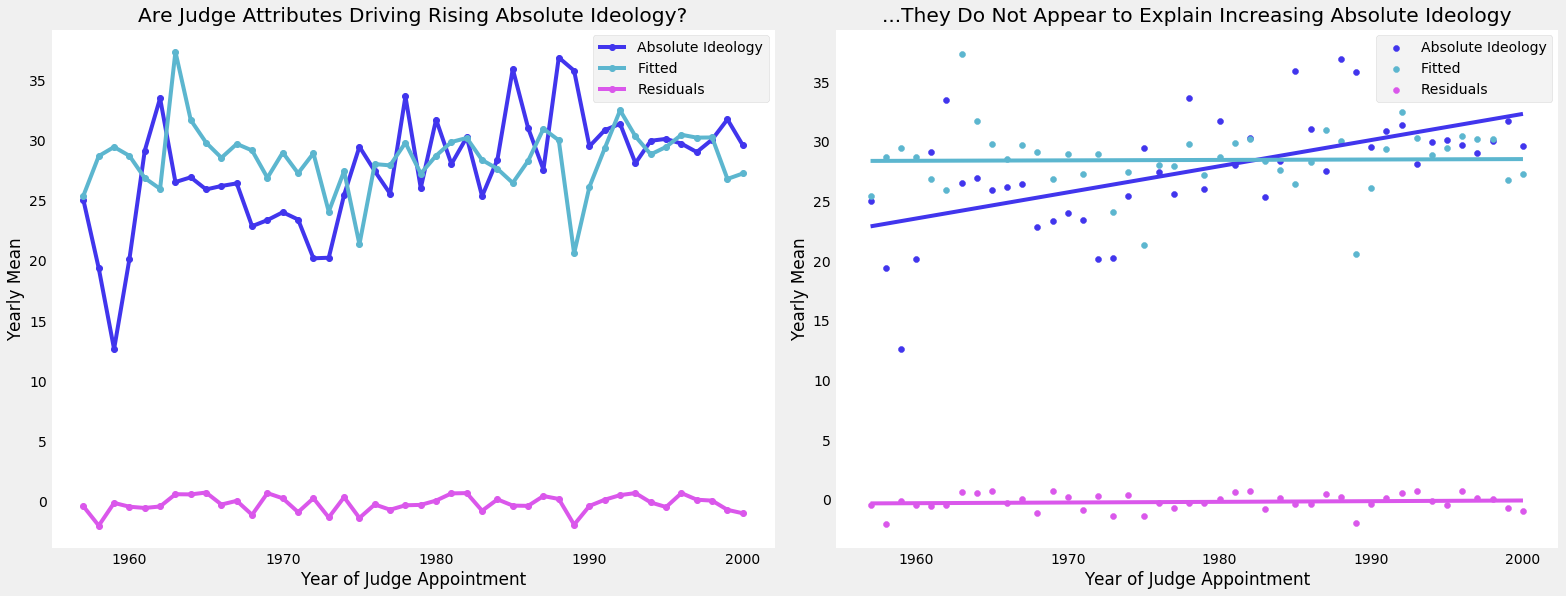

In [98]:
from scipy import stats

plt.style.use("fivethirtyeight")

fig, ax = plt.subplots(1,2,figsize=(22,8.5))

# Hide grid lines, set a white face color
#"#5cb6cf",
colors = ["#4135ed" ,"#5cb6cf","#da57eb"]

#colors = ["#4135ed" ,,"#1473a6"]
    
#Plotting trends in observed absolute ideology, fitted and residual values     
for counter,value in enumerate(["Absolute Ideology","Fitted","Residuals"]):
    ax[0].plot(year_decomposition["Year of Appointment"],
                    year_decomposition[value],"-o", color = colors[counter],label=value)
    ax[1].scatter(year_decomposition["Year of Appointment"],
                    year_decomposition[value],  color = colors[counter],label=value)
    slope, intercept, r_value, p_value, std_err = stats.linregress(year_decomposition["Year of Appointment"],year_decomposition[value])
    line = slope*year_decomposition["Year of Appointment"]+intercept
    ax[1].plot(year_decomposition["Year of Appointment"], line,color=colors[counter],label="_")
      
ax[0].set_title("Are Judge Attributes Driving Rising Absolute Ideology?")   
ax[1].set_title("...They Do Not Appear to Explain Increasing Absolute Ideology")   

for n in [0,1]:
    ax[n].set_facecolor('white')
    ax[n].grid(False)
    ax[n].set_ylabel("Yearly Mean")
    ax[n].set_xlabel("Year of Judge Appointment")
    ax[n].legend()

fig.tight_layout()


In [100]:
# SAME AS ABOVE BUT WITHOUT RESIDUALS
#QUESTION FOR IAN: does removing residuals look better? 
#If NOT, then we can delete the next few cells

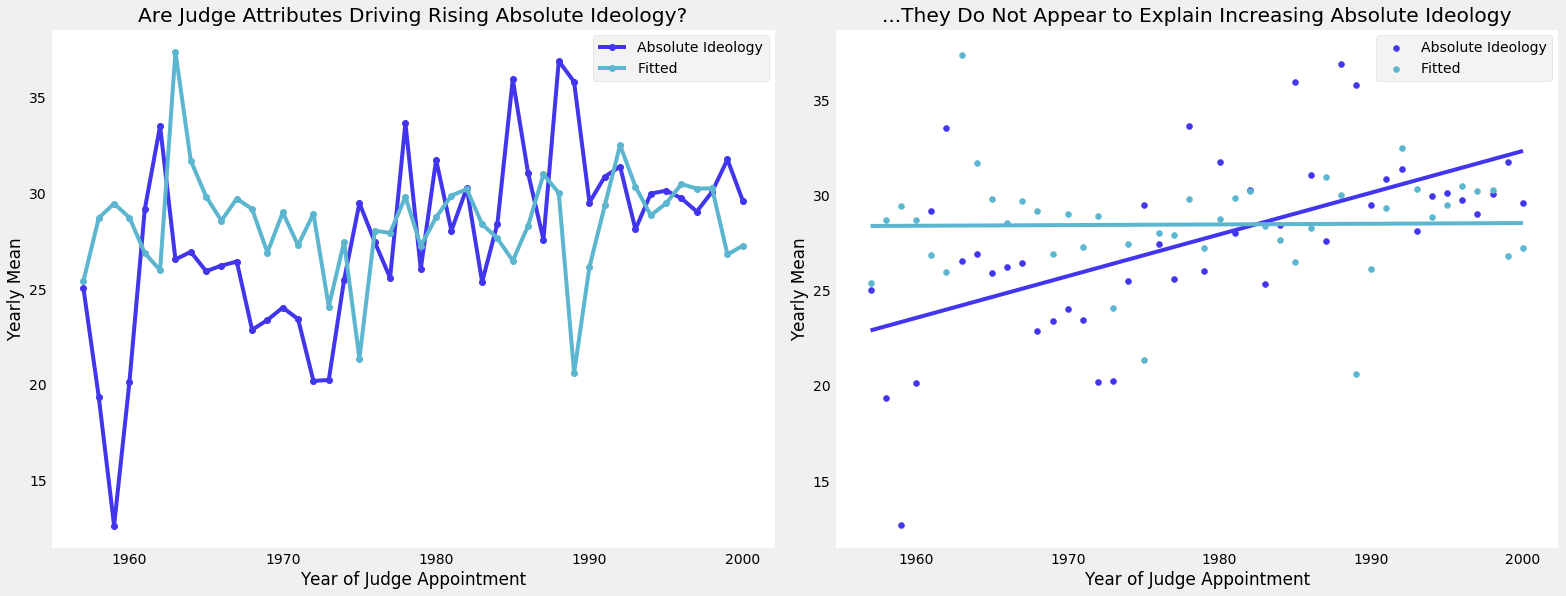

In [99]:
plt.style.use("fivethirtyeight")

fig, ax = plt.subplots(1,2,figsize=(22,8.5))


colors = ["#4135ed" ,"#5cb6cf"]
    
for counter,value in enumerate(["Absolute Ideology","Fitted"]):
    ax[0].plot(year_decomposition["Year of Appointment"],
                    year_decomposition[value],"-o", color = colors[counter],label=value)
    ax[1].scatter(year_decomposition["Year of Appointment"],
                    year_decomposition[value],  color = colors[counter],label=value)
    slope, intercept, r_value, p_value, std_err = stats.linregress(year_decomposition["Year of Appointment"],year_decomposition[value])
    line = slope*year_decomposition["Year of Appointment"]+intercept
    ax[1].plot(year_decomposition["Year of Appointment"], line,color=colors[counter],label="_")
      
ax[0].set_title("Are Judge Attributes Driving Rising Absolute Ideology?")   
ax[1].set_title("...They Do Not Appear to Explain Increasing Absolute Ideology")   



for n in [0,1]:
    ax[n].set_facecolor('white')
    ax[n].grid(False)
    ax[n].set_ylabel("Yearly Mean")
    ax[n].set_xlabel("Year of Judge Appointment")
    ax[n].legend()

fig.tight_layout()

The fitted values do not show an increase in predicted absolute ideology over time. But part of the reason is structural: we are controlling for year of appointment and other variables that vary over time such as appointed president. Next, we'll look at whether the judge's static _personal_ attributes (excluding age) predict the rise in absolute over time. We'll use the following variables: race, gender, previous job experience, judge's political party, and American Bar Association Rating (level of qualification).

First, we'll look at how judge personal attributes have changed over time. 

In [47]:
#Subset of full dataframe with only key judge personal attributes, as well as year of appointment
judges_personal = judges_ideology[["Age When Appointed","Race","Gender","Judge Party","Politician","ABA Rating","Year of Appointment"]]

#Manual "one-hot encoding" or in other words
#creating columns which serve as indicator variables for key attributes
for race_name in ["White","African American"]:
    judges_personal[race_name] = [1 if race == race_name else 0 for race in judges_personal["Race"]]

judges_personal["Female"] = [1 if gender == "Female" else 0 for gender in judges_personal["Gender"]]
judges_personal["Republican"] = [1 if party == "Republican" else 0 for party in judges_personal["Judge Party"]]
judges_personal["Well Qualified"] = [1 if rating == "Well-Qual." else 0 for rating in judges_personal["ABA Rating"]]

mean_age = np.mean(judges["Age When Appointed"])
judges_personal["Young"] = [1 if age < mean_age else 0 for age in judges_personal["Age When Appointed"]]

judges_personal.head()

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs

,Age When Appointed,Race,Gender,Judge Party,Politician,ABA Rating,Year of Appointment,White,African American,Female,Republican,Well Qualified,Young
2,55.0,White,Male,Republican,0,Qualified,1982,1,0,0,1,0,0
3,51.0,White,Male,Democrat,1,Well-Qual.,1979,1,0,0,0,1,0
4,50.0,White,Male,Republican,0,Well-Qual.,1976,1,0,0,1,1,1
5,57.0,Hispanic,Male,Republican,0,Qualified,1982,0,0,0,1,0,0
10,48.0,African American,Male,Democrat,0,Qualified,1993,0,1,0,0,0,1


In [74]:
#Dataframe with the average fraction of judges with each personal attribute by year
year_personal = judges_personal.groupby("Year of Appointment")[["White","African American",
                                                               "Female","Republican","Well Qualified","Young"]].mean()

#multiplying by 100 to provide percentage term interpretation 
for name in list(year_personal):
    year_personal[name] = 100*year_personal[name]
    
year_personal.head(n=15)  

,White,African American,Female,Republican,Well Qualified,Young
Year of Appointment,,,,,,
1957,100.000000,0.000000,0.000000,100.000000,46.153846,30.769231
1958,100.000000,0.000000,0.000000,90.909091,36.363636,27.272727
1959,100.000000,0.000000,0.000000,83.333333,50.000000,33.333333
1960,100.000000,0.000000,0.000000,100.000000,45.454545,54.545455
1961,95.081967,3.278689,0.000000,0.000000,47.540984,47.540984
1962,100.000000,0.000000,3.225806,29.032258,41.935484,29.032258
1963,100.000000,0.000000,0.000000,0.000000,66.666667,11.111111
1964,92.857143,7.142857,0.000000,0.000000,14.285714,64.285714
1965,94.736842,5.263158,0.000000,5.263158,52.631579,47.368421


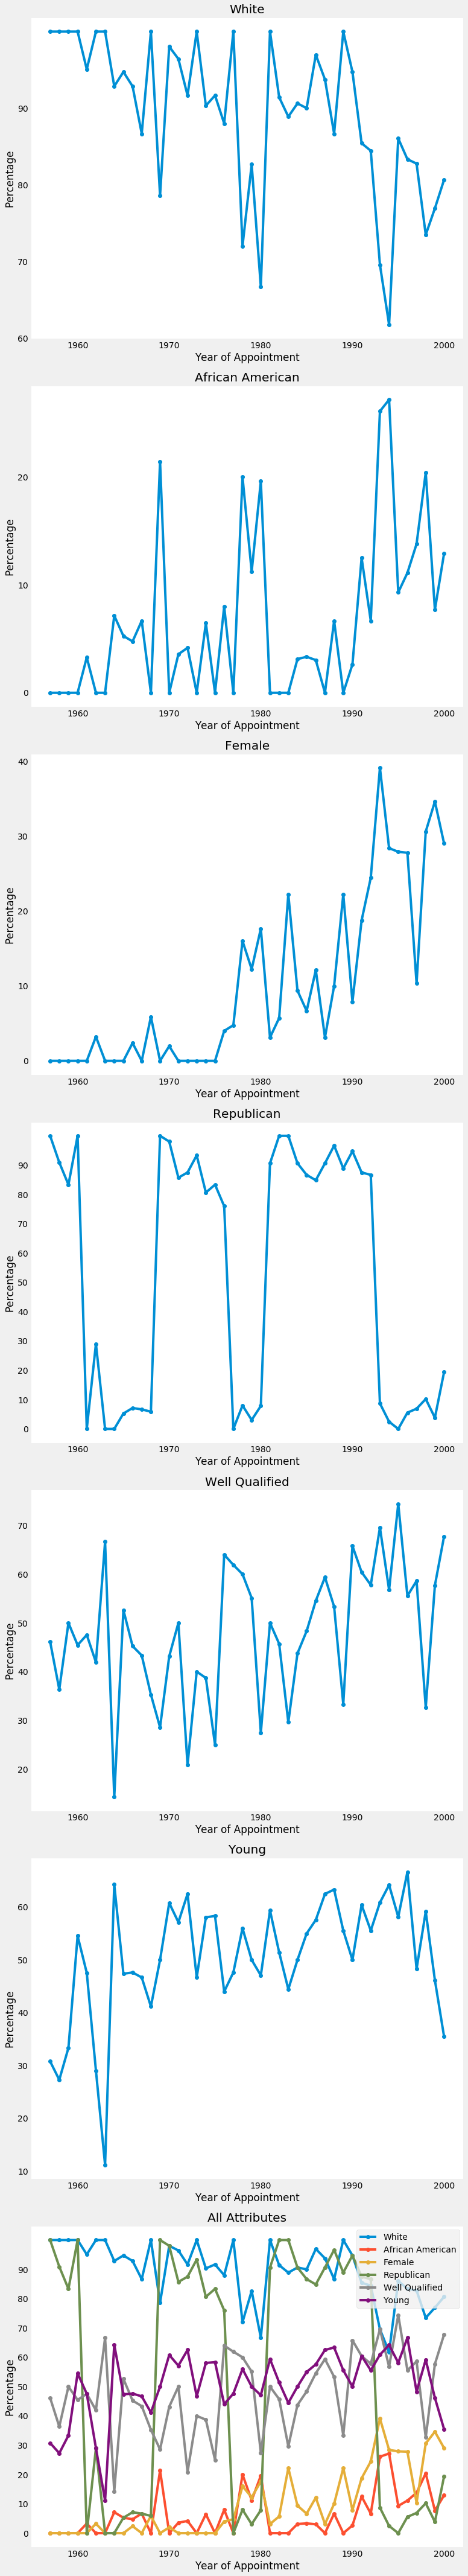

In [92]:
#This plot shows considerable variation over time in the proportion of judges 
#with each of the personal attributes 

fig, ax = plt.subplots(7,1,figsize=(11,8.5*7))

for counter,attribute in enumerate(list(year_personal)):
    ax[counter].set_facecolor('white')
    ax[counter].grid(False)
    ax[counter].set_ylabel("Percentage")
    ax[counter].set_xlabel("Year of Appointment")
    ax[counter].set_yticks(range(0,100,10))
    ax[counter].plot(list(year_personal.index),year_personal[attribute],"-o",label=attribute)
    ax[counter].set_title(attribute)
    

#all the attributes in one plot (a bit overwhelming, but makes for comparison)
for attribute in list(year_personal):
    ax[6].set_facecolor('white')
    ax[6].grid(False)
    ax[6].set_ylabel("Percentage")
    ax[6].set_xlabel("Year of Appointment")
    ax[6].set_yticks(range(0,100,10))
    ax[6].plot(list(year_personal.index),year_personal[attribute],"-o",label=attribute)
    ax[6].set_title("All Attributes")
    ax[6].legend()
    


fig.tight_layout()


As the plot above shows, there variation in judge attributes over time. But do the changing attributes predict changing ideology?

Now we'll determine whether static personal attributes help explain rising judge absolute ideology.

In [36]:
#we'll add "P" to the varialbe names to refer to "personal" and distinguish them from the variables above
continuous_variablesP = ["Age When Appointed",
 'Previous Position - slc',
 'Previous Position - locct',
 'Previous Position - sjdget',
 'Previous Position - ausa',
 'Previous Position - usa',
 'Previous Position - sgo',
 'Previous Position - sg',
 'Previous Position - ago',
 'Previous Position - ag',
 'Previous Position - cc',
 'Previous Position - sp',
 'Previous Position - mag',
 'Previous Position - bank',
 'Previous Position - terr',
 'Previous Position - cab',
 'Previous Position - asatty',
 'Previous Position - satty',
 'Previous Position - cabdept',
 'Previous Position - scab',
 'Previous Position - scabdpt',
 'Previous Position - aag',
 'Previous Position - indreg1',
 'Previous Position - reg1',
 'Previous Position - reg2',
 'Previous Position - reg3',
 'Previous Position - house',
 'Previous Position - senate',
 'Previous Position - gov',
 'Previous Position - ssenate',
 'Previous Position - shouse',
 'Previous Position - mayor',
 'Previous Position - ccoun',
 'Previous Position - ccom',
 'Previous Position - ada',
 'Previous Position - da',
 'Previous Position - lother',
 'Previous Position - lotherl',
 'Previous Position - lawprof',
 'Previous Position - private']
                     
    
#categorical variables 

categoriesP = ['Judge Party','Gender','Race','ABA Rating']


# using the fulldataset is equivalent to setting test_size = 0 
X_fullP, X_empty_test, abs_ideo_fullP, abs_ideo_empty_train = prep_data(
    judges_ideology,continuous_variablesP , categoriesP, "Absolute Ideology",test_size=0
)

#fitted values
abs_ideo_hatP = forest_model.fit(X_fullP,abs_ideo_fullP).predict(X_fullP)

#residuals
abs_ideo_residP = abs_ideo_fullP - abs_ideo_hatP

#Similar to above, creating dataframe with mean observed, residual and fitted values by year
judges_decompositionP = judges_ideology[["Year of Appointment","State","Absolute Ideology"]]
judges_decompositionP["Residuals"] = abs_ideo_residP
judges_decompositionP["Fitted"] = abs_ideo_hatP
year_decompositionP =  judges_decompositionP.groupby("Year of Appointment")[["Absolute Ideology","Residuals","Fitted"]].mean()
year_decompositionP.reset_index(inplace = True)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


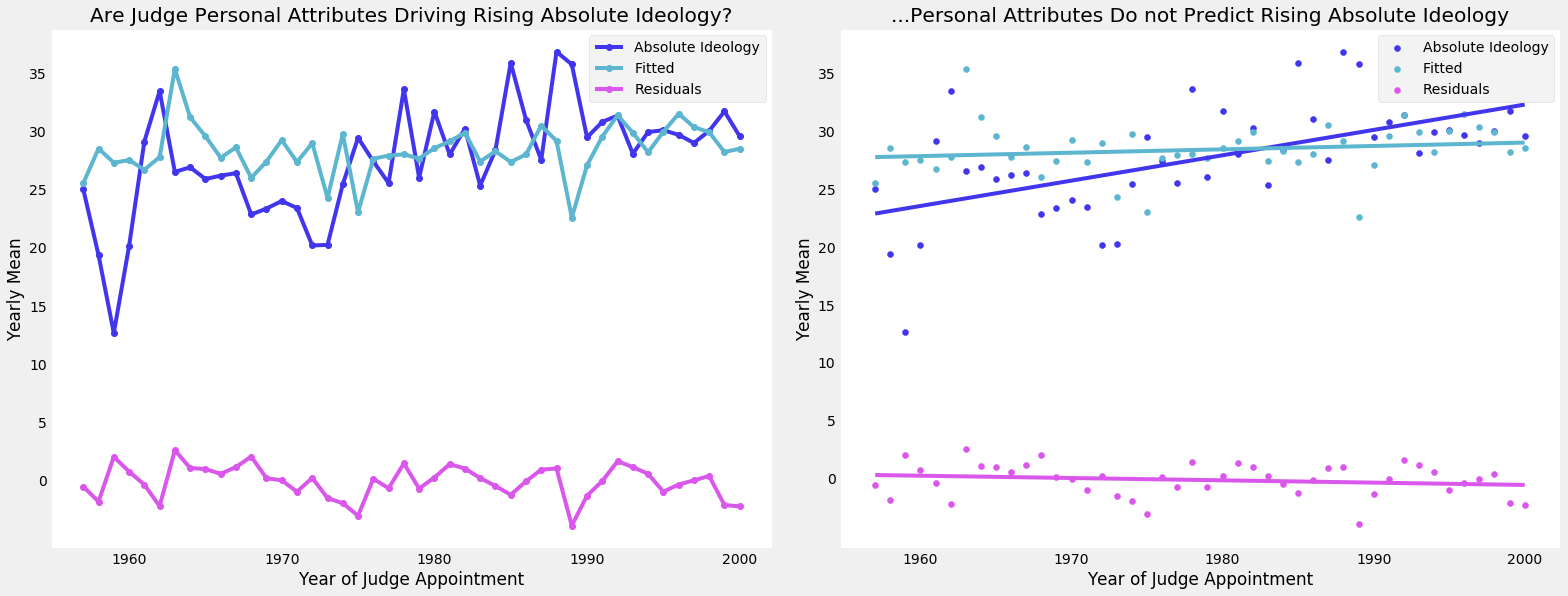

In [95]:
from scipy import stats

plt.style.use("fivethirtyeight")

fig, ax = plt.subplots(1,2,figsize=(22,8.5))

colors = ["#4135ed" ,"#5cb6cf","#da57eb"]

#plotting trends in observed, residual and fitted values
for counter,value in enumerate(["Absolute Ideology","Fitted","Residuals"]):
    ax[0].plot(year_decompositionP["Year of Appointment"],
                    year_decompositionP[value],"-o", color = colors[counter],label=value)
    ax[1].scatter(year_decompositionP["Year of Appointment"],
                    year_decompositionP[value],  color = colors[counter],label=value)
    slope, intercept, r_value, p_value, std_err = stats.linregress(year_decompositionP["Year of Appointment"],year_decompositionP[value])
    line = slope*year_decompositionP["Year of Appointment"]+intercept
    ax[1].plot(year_decompositionP["Year of Appointment"], line,color=colors[counter],label="_")
      
ax[0].set_title("Are Judge Personal Attributes Driving Rising Absolute Ideology?")   
ax[1].set_title("...Personal Attributes Do not Predict Rising Absolute Ideology")
for n in [0,1]:
    ax[n].set_facecolor('white')
    ax[n].grid(False)
    ax[n].set_ylabel("Yearly Mean")
    ax[n].set_xlabel("Year of Judge Appointment")
    ax[n].legend()
    ax[n].set_yticks(range(0,40,5))

fig.tight_layout()


# Estimating Nuisance Function 

We'll estimate the influence of judge political experience on judge ideology

Are judges with past experience as elected officials more ideological?

We'll estimate regressions of the form 

$$Y = \beta Politician + f(x) + \epsilon $$

,where $Y$ is ideology or absolute ideology, $Politician$ is an indicator for past politican experience, and $f(x)$ is the nuisance function for the controls (judge attributes) 

## Preparing Data

In [193]:
#creating a dataframe which is ready for regressions/partial regressions

#Setting continuous variables for this analysis
#(the categories are the same as the ones above)

continuous_variables2 = ["Ideology Score","Absolute Ideology","Politician",
                          'Previous Position - house', 'Previous Position - senate',
                         'Previous Position - gov','Previous Position - ssenate',
                         'Previous Position - shouse','Previous Position - mayor',
                         'Previous Position - ccoun',
                         'House Democrats',
                        'House Republicans',
                        'Senate Democrats',
                        'Senate Republicans',
                        'House Independents',
                        'Senate Independents']

political_judges = judges_ideology[continuous_variables2]

political_judges.reset_index(inplace = True)
political_judges = political_judges.drop(["index"],axis=1)
political_judges.head()

,Ideology Score,Absolute Ideology,Politician,Previous Position - house,Previous Position - senate,Previous Position - gov,Previous Position - ssenate,Previous Position - shouse,Previous Position - mayor,Previous Position - ccoun,House Democrats,House Republicans,Senate Democrats,Senate Republicans,House Independents,Senate Independents
0,40.700001,40.700001,0,0,0,0,0,0,0,0,243,192,47,53,0,0
1,-30.599999,30.599999,1,1,0,0,0,0,0,0,277,158,59,41,0,0
2,6.100000,6.100000,0,0,0,0,0,0,0,0,291,144,61,38,0,0
3,53.799999,53.799999,0,0,0,0,0,0,0,0,243,192,47,53,0,0
4,-22.600000,22.600000,0,0,0,0,0,0,0,0,258,176,57,43,1,0


In [194]:
ohe = preprocessing.OneHotEncoder(sparse=False)

political_judges_dummies = pd.DataFrame.from_records(ohe.fit_transform(judges_ideology[categories]))

dummy_columns = ["dummy" + str(i) for i in range(654)]

political_judges_dummies.columns = dummy_columns
political_judges_dummies.head(n=10)



,dummy0,dummy1,dummy2,dummy3,dummy4,dummy5,dummy6,dummy7,dummy8,dummy9,...,dummy644,dummy645,dummy646,dummy647,dummy648,dummy649,dummy650,dummy651,dummy652,dummy653
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
8,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


In [195]:
political_judges = pd.concat([political_judges, political_judges_dummies],axis=1)
political_judges.head()

,Ideology Score,Absolute Ideology,Politician,Previous Position - house,Previous Position - senate,Previous Position - gov,Previous Position - ssenate,Previous Position - shouse,Previous Position - mayor,Previous Position - ccoun,...,dummy644,dummy645,dummy646,dummy647,dummy648,dummy649,dummy650,dummy651,dummy652,dummy653
0,40.700001,40.700001,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1,-30.599999,30.599999,1,1,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2,6.100000,6.100000,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
3,53.799999,53.799999,0,0,0,0,0,0,0,0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,-22.600000,22.600000,0,0,0,0,0,0,0,0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


## OLS 

First, we'll run the OLS regression

In [196]:
import statsmodels.formula.api as smf
from statsmodels.iolib.summary2 import summary_col
from patsy.builtins import *

In [197]:
#We have hundreds of dummy variables, and including them manually in the regression would be tedious

def list_to_formula(var_list):
    """ 
    Given a list of variable names: var1, var2, ... varN,
    Output single string: + var1 + var2 + ... + varN
    """
    output = ""
    for var in var_list:
        output = output + " + " + var
    return output

In [198]:
#To include variables with spaces in their name in the regression
#We need to rely on patsy and put them in the form Q('variable name')

congress_composition = ['House Democrats','House Republicans','Senate Democrats',
                        'Senate Republicans','House Independents','Senate Independents',]

congress_composition_Q = ["Q('" + val + "')" for val in congress_composition]

composition_formula = list_to_formula(congress_composition_Q)

#We'll also make a formula for the dummy variables
dummies_formula = list_to_formula(dummy_columns)

In [199]:
# Estimating three variations of the model (adding controls)
lm_ideo = list()
lm_ideo.append(smf.ols(formula="Q('Ideology Score') ~ Politician", data=political_judges,
                  missing="drop").fit(cov_type='HC0'))

lm_ideo.append(smf.ols(formula="Q('Ideology Score') ~ Politician" + composition_formula
                  ,data=political_judges,
                  missing="drop").fit(cov_type='HC0'))

lm_ideo.append(smf.ols(formula="Q('Ideology Score') ~ Politician" + composition_formula + dummies_formula
                  ,data=political_judges,
                  missing="drop").fit(cov_type='HC0'))


#notably, the inclusion of the dummies (important controls) flipped the sign of the Politician coefficient! 
summary_col(lm_ideo, stars=True)

/opt/conda/lib/python3.6/site-packages/statsmodels/base/model.py:1100: RuntimeWarning: invalid value encountered in true_divide
  return self.params / self.bse
/opt/conda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/opt/conda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/opt/conda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


,Q('Ideology Score') I,Q('Ideology Score') II,Q('Ideology Score') III
Intercept,-1.5510*,1104.0585***,0.2721
,(0.9003),(97.9475),(0.2390)
Politician,-1.7957,-1.2555,1.7023
,(2.6717),(2.3194),(1.3807)
Q('House Democrats'),,-0.6835***,0.1280
,,(0.0965),(0.1688)
Q('House Independents'),,-19.0197***,1.6115
,,(2.0924),(1.7263)
Q('House Republicans'),,-1.1714***,0.0014
,,(0.1111),(0.1310)


In [200]:
# Repeaeting with absolute ideology as the outcome 
lm_asb_ideo = list()
lm_asb_ideo.append(smf.ols(formula="Q('Absolute Ideology') ~ Politician", data=political_judges,
                  missing="drop").fit(cov_type='HC0'))

lm_asb_ideo.append(smf.ols(formula="Q('Absolute Ideology') ~ Politician" + composition_formula
                  ,data=political_judges,
                  missing="drop").fit(cov_type='HC0'))

lm_asb_ideo.append(smf.ols(formula="Q('Absolute Ideology') ~ Politician" + composition_formula + dummies_formula
                  ,data=political_judges,
                  missing="drop").fit(cov_type='HC0'))

#inclusion of the full set of dummies flipped the sign of the Politician coefficient, again
summary_col(lm_asb_ideo, stars=True)

,Q('Absolute Ideology') I,Q('Absolute Ideology') II,Q('Absolute Ideology') III
Intercept,28.5407***,-272.0906***,-0.3419*
,(0.4117),(64.0601),(0.1971)
Politician,-1.8292,-0.6761,0.3298
,(1.3808),(1.4009),(1.5538)
Q('House Democrats'),,0.1698***,-0.0750
,,(0.0627),(0.1381)
Q('House Independents'),,1.8830*,1.4025
,,(0.9781),(1.7199)
Q('House Republicans'),,0.1181*,-0.0537
,,(0.0674),(0.1129)


## Partial linear regression with Lasso

In [201]:
from sklearn.model_selection import cross_val_predict
from sklearn import linear_model
import statsmodels as sm

def partial_linear(y, d, X, yestimator, destimator, folds=3):
    """Estimate the partially linear model y = d*C + f(x) + e

    Parameters
    ----------
    y : array_like
        vector of outcomes
    d : array_like
        vector or matrix of regressors of interest
    X : array_like
        matrix of controls
    mlestimate : Estimator object for partialling out X. Must have ‘fit’
        and ‘predict’ methods.
    folds : int
        Number of folds for cross-fitting

    Returns
    -------
    ols : statsmodels regression results containing estimate of coefficient on d.
    yhat : cross-fitted predictions of y
    dhat : cross-fitted predictions of d
    """

    # we want predicted probabilities if y or d is discrete
    ymethod = "predict" if False==getattr(yestimator, "predict_proba",False) else "predict_proba"
    dmethod = "predict" if False==getattr(destimator, "predict_proba",False) else "predict_proba"
    # get the predictions
    yhat = cross_val_predict(yestimator,X,y,cv=folds,method=ymethod)
    dhat = cross_val_predict(destimator,X,d,cv=folds,method=dmethod)
    ey = np.array(y - yhat)
    ed = np.array(d - dhat)
    ols = sm.regression.linear_model.OLS(ey,ed).fit(cov_type='HC0')

    return(ols, yhat, dhat)

In [202]:
from patsy import dmatrices
# Prepare data
formula="Q('Ideology Score') + Q('Absolute Ideology') + Politician ~ " + composition_formula + dummies_formula

yd, X = dmatrices(formula,political_judges)
ideo = yd[:,0]
abs_ideo = yd[:,1]
politician = yd[:,2]

In [203]:
# we use another list of alphas compared to the above, so this is number 2
alphas2 = np.exp(np.linspace(1.5, -10., 25))
lasso_ideo = linear_model.LassoCV(cv=6, alphas=alphas2, max_iter=500).fit(X,ideo)
lasso_abs_ideo = linear_model.LassoCV(cv=6, alphas=alphas2, max_iter=500).fit(X,abs_ideo)
lasso_politician = linear_model.LassoCV(cv=6, alphas=alphas2, max_iter=500).fit(X,politician)

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of

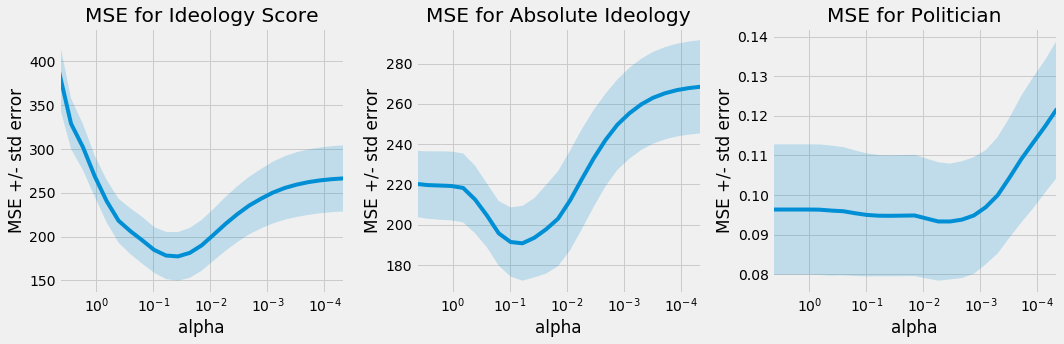

In [204]:
fig, ax = plt.subplots(1,3, figsize=(15,5))

#plotting the MSE for the two outcomes and the explanatory variable, "Politician"
def plotlassocv(l, ax) :
    alphas = l.alphas_
    mse = l.mse_path_.mean(axis=1)
    std_error = l.mse_path_.std(axis=1)
    ax.plot(alphas,mse)
    ax.fill_between(alphas, mse + std_error, mse - std_error, alpha=0.2)

    ax.set_ylabel('MSE +/- std error')
    ax.set_xlabel('alpha')
    ax.set_xlim([alphas[0], alphas[-1]])
    ax.set_xscale("log")
    return(ax)
   
ax[0] = plotlassocv(lasso_ideo,ax[0])
ax[0].set_title("MSE for Ideology Score")
ax[1] = plotlassocv(lasso_abs_ideo,ax[1])
ax[1].set_title("MSE for Absolute Ideology")
ax[2] = plotlassocv(lasso_politician,ax[2])
ax[2].set_title("MSE for Politician")

fig.tight_layout()

In [205]:
#summarizing the lasso model partial regression
pl_lasso_ideo = partial_linear(ideo, politician, X,
                          linear_model.Lasso(alpha=lasso_ideo.alpha_),
                          linear_model.Lasso(alpha=lasso_politician.alpha_))
pl_lasso_ideo[0].summary()

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                   0.02221
Date:                Tue, 16 Apr 2019   Prob (F-statistic):              0.882
Time:                        23:40:28   Log-Likelihood:                -5708.4
No. Observations:                1420   AIC:                         1.142e+04
Df Residuals:                    1419   BIC:                         1.142e+04
Df Model:                           1                                         
Covariance Type:                  HC0                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.1924      1.291      0.149      0.882      -2.338       2.723
==============================================================================
Omnibus:                       45.691   Durbin-Watson:                   2.000
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              115.136
Skew:                           0.056   Prob(JB):                     9.97e-26
Kurtosis:                       4.390   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity robust (HC0)
"""

In [206]:
pl_lasso_abs_ideo = partial_linear(abs_ideo, politician, X,
                          linear_model.Lasso(alpha=lasso_abs_ideo.alpha_),
                          linear_model.Lasso(alpha=lasso_politician.alpha_))
pl_lasso_abs_ideo[0].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.5756
Date:                Tue, 16 Apr 2019   Prob (F-statistic):              0.448
Time:                        23:40:30   Log-Likelihood:                -5762.4
No. Observations:                1420   AIC:                         1.153e+04
Df Residuals:                    1419   BIC:                         1.153e+04
Df Model:                           1                                         
Covariance Type:                  HC0                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -1.0393      1.370     -0.759      0.448      -3.724       1.646
==============================================================================
Omnibus:                       31.882   Durbin-Watson:                   1.942
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               18.034
Skew:                           0.085   Prob(JB):                     0.000121
Kurtosis:                       2.475   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity robust (HC0)
"""

## Partial linear regression with Random Forests

In [207]:
#Fitting the forst model
forest_ideo = RandomForestRegressor(n_estimators = 100).fit(X,ideo)
forest_abs_ideo = RandomForestRegressor(n_estimators = 100).fit(X,abs_ideo)
fores_politician = RandomForestRegressor(n_estimators = 100).fit(X,politician)



In [208]:
#Summarizing the partial linear regression with Random Forests
pl_forest_ideo = partial_linear(ideo, politician, X,
                          RandomForestRegressor(n_estimators = 100),
                          RandomForestRegressor(n_estimators = 100))
pl_lasso_ideo[0].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                   0.02221
Date:                Tue, 16 Apr 2019   Prob (F-statistic):              0.882
Time:                        23:40:59   Log-Likelihood:                -5708.4
No. Observations:                1420   AIC:                         1.142e+04
Df Residuals:                    1419   BIC:                         1.142e+04
Df Model:                           1                                         
Covariance Type:                  HC0                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.1924      1.291      0.149      0.882      -2.338       2.723
==============================================================================
Omnibus:                       45.691   Durbin-Watson:                   2.000
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              115.136
Skew:                           0.056   Prob(JB):                     9.97e-26
Kurtosis:                       4.390   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity robust (HC0)
"""

In [209]:
pl_forest_abs_ideo = partial_linear(abs_ideo, politician, X,
                          RandomForestRegressor(n_estimators = 100),
                          RandomForestRegressor(n_estimators = 100))
pl_forest_abs_ideo[0].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                   0.03085
Date:                Tue, 16 Apr 2019   Prob (F-statistic):              0.861
Time:                        23:41:16   Log-Likelihood:                -5235.7
No. Observations:                1420   AIC:                         1.047e+04
Df Residuals:                    1419   BIC:                         1.048e+04
Df Model:                           1                                         
Covariance Type:                  HC0                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.1646      0.937     -0.176      0.861      -2.001       1.672
==============================================================================
Omnibus:                       49.513   Durbin-Watson:                   1.953
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              121.700
Skew:                          -0.125   Prob(JB):                     3.74e-27
Kurtosis:                       4.412   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity robust (HC0)
"""

## Partial linear regression with Neural Networks

In [210]:
#Summarizing the neural network model's partial linear regression
pl_nn_ideo = partial_linear(ideo, politician, X,
                          nn_scaled_model, #from above
                          nn_scaled_model)

pl_nn_ideo[0].summary()

/opt/conda/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                   0.08848
Date:                Tue, 16 Apr 2019   Prob (F-statistic):              0.766
Time:                        23:49:45   Log-Likelihood:                -5854.2
No. Observations:                1420   AIC:                         1.171e+04
Df Residuals:                    1419   BIC:                         1.172e+04
Df Model:                           1                                         
Covariance Type:                  HC0                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.3255      1.094      0.297      0.766      -1.819       2.470
==============================================================================
Omnibus:                      103.245   Durbin-Watson:                   1.994
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              385.609
Skew:                          -0.258   Prob(JB):                     1.84e-84
Kurtosis:                       5.500   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity robust (HC0)
"""

In [212]:
pl_nn_abs_ideo = partial_linear(abs_ideo, politician, X,
                          nn_scaled_model,
                          nn_scaled_model)

pl_nn_abs_ideo[0].summary()

/opt/conda/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.009
Date:                Wed, 17 Apr 2019   Prob (F-statistic):              0.315
Time:                        00:04:07   Log-Likelihood:                -5846.5
No. Observations:                1420   AIC:                         1.170e+04
Df Residuals:                    1419   BIC:                         1.170e+04
Df Model:                           1                                         
Covariance Type:                  HC0                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -1.0410      1.036     -1.005      0.315      -3.072       0.990
==============================================================================
Omnibus:                       13.074   Durbin-Watson:                   1.945
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               14.364
Skew:                           0.179   Prob(JB):                     0.000760
Kurtosis:                       3.339   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity robust (HC0)
"""

## Summary of partial linear models 

In [215]:
summary_col([pl_lasso_ideo[0], pl_forest_ideo[0],pl_nn_ideo[0]],
            model_names=["Lasso", "Random Forest","Neural Network"] ,stars=False)

,Lasso,Random Forest,Neural Network
x1,0.1924,-0.7186,0.3255
,(1.2910),(0.9666),(1.0942)


In [216]:
summary_col([pl_lasso_abs_ideo[0], pl_forest_abs_ideo[0], pl_nn_abs_ideo[0]],
            model_names=["Lasso", "Random Forest","Neural Network"],stars=False)



,Lasso,Random Forest,Neural Network
x1,-1.0393,-0.1646,-1.0410
,(1.3698),(0.9371),(1.0363)


Random Forest was most effective in minimizing MSE in the previous section. It's interesting it yields such different estimates than Lasso and Neural Network. Overall, due to the precise (and somewhat noisy estimates across methods), we don't have evidence that past political experience is highly correlated with either ideology or absolute.